# COVID-19 Machine Learning Dataset
## Intended For Educational Use Only

>Adopted from the dataset provided by Dr. Karandeep Singh [@kdpsinghlab](https://twitter.com/kdpsinghlab/status/1239416911668092928)

The goal of this case study (intended for education) is to **predict the urgency** with which a COVID-19 patient will need to be admitted to the hospital from the time of onset of symptoms

The original dataset is located on this [github repo](https://github.com/ml4lhs/covid19_ml_education/raw/master/covid_ml.csv) and has been simplified for this case study

The raw data comes from the following source: http://virological.org/t/epidemiological-data-from-the-ncov-2019-outbreak-early-descriptions-from-publicly-available-data/337


**Primary predictors:**
- age (if an age range was provided in the source data, only the first number is used)
- sex
- cough, fever, chills, sore_throat, headache, fatigue (all derived from the symptoms column using regular expressions)

>The goal of the exercise is to make a classification model to predict the **urgency_of_admission** based on the following criteria
1. 0-1 days from onset of symptoms to admission => High
2. 2+ days from onset of symptoms to admission *or* no admission => Low
  

## Should this data be used for research?

No. Students working with this dataset should understand that both the source data and the ML data have several limitations:
- The source data is crowdsourced and may contain inaccuracies.
- There may be duplicate patients in this dataset
- There is a substantial amount of missingness in the symptoms data.

## **And most importantly:**
- The entire premise is flawed. The fact that a patient was admitted the same day as experiencing symptoms may have more to do with the availability of hospital beds as opposed to the patient's acuity of illness.
- Also, the fact that less sick patients or asymptomatic patients may not have been captured in the source dataset mean that the probabilities estimated by any model fit on this data are unlikely to reflect reality.


## BEGIN HERE

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Forgotten imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns

## Calling the dataset
>We are using a modified dataset found here [covid_19 dataset source](Link)

Following changes were made:
1. Categorical values changed to 1 and 0
2. Used SMOTE to upsample in order to balance the dataset

In [2]:
df = pd.read_csv('covid_fixed.csv')
df.head()

,age,sex,cough,fever,chills,sore_throat,headache,fatigue,Urgency
0,30,1,0,0,0,0,0,0,Low
1,47,1,0,0,0,0,0,0,Low
2,49,1,0,0,0,0,0,0,Low
3,47,0,0,0,0,0,0,0,Low
4,50,0,0,0,0,0,0,0,Low


In [3]:
df.Urgency = df.Urgency.map({'High':1, 'Low':0})

In [4]:
# Separating dependent and independent variable
X, y = df.iloc[:,:-1], df.iloc[:,-1]
#Setting up an index for train, test split
split_index = np.array(range(len(X)))
itrain, itest = train_test_split(split_index, test_size = 0.2)

#creating a mask to quickly access train and test data
mask = np.zeros(len(X), dtype = 'int')
mask[itrain] = 1
mask = mask==1

## GridsearchCV for Logistic Regression
>Below we do a hyper-parameter search to get the best C value for Logistic Regression
>> For simplicity, We will use the **Accuracy** as a scorer metric to choose best hyper-paramete

In [5]:
#Defining a useful function that takes a set of hyper-parameters and gives us the best option
def best_classifier(clf, params, X,y, n_folds = 5):
    gs = GridSearchCV(clf, param_grid = params, cv=n_folds)
    gs.fit(X,y)
    print("BEST", gs.best_params_, round(gs.best_score_,2))
    best = gs.best_estimator_
    return best

In [6]:
#Tuning for Logistic regression
logreg = LogisticRegression(solver= 'lbfgs', max_iter=10000)
c_values = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Finding the best value of C
best = best_classifier(logreg, c_values, X[mask], y[mask], n_folds = 5)

BEST {'C': 0.1} 0.61


## Fitting the data and making predictions
>We will also calculate the accuracy and display the confusion matrix

In [7]:
logreg = LogisticRegression(max_iter=1000,solver = 'lbfgs',C=10000)

logreg.fit(X[mask], y[mask])

y_pred = logreg.predict(X[~mask])
cm_test = confusion_matrix(y[~mask], y_pred)

cm_test

print(f'Accuracy for test set for Logistic Regression = {(cm_test[0][0] + cm_test[1][1])/len(y[~mask]):.2f}')

Accuracy for test set for Logistic Regression = 0.59


In [8]:
logreg.classes_

array([0, 1])

## Time to find best k value

In [9]:
from sklearn.neighbors import KNeighborsClassifier
neighbor = KNeighborsClassifier()
k_vals = np.arange(1,50,3)
n_vals = {"n_neighbors": k_vals}

In [10]:
best = best_classifier(neighbor, n_vals, X[mask], y[mask], n_folds = 5)

BEST {'n_neighbors': 10} 0.63


## Now we try to do k-nn classification

In [11]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X[mask], y[mask])

y_kpred = neigh.predict(X[~mask])

cmk_test = confusion_matrix(y[~mask], y_kpred)

cmk_test

print(f'Accuracy for test set for K-nn classification = {(cmk_test[0][0] + cmk_test[1][1])/len(y[~mask]):.2f}')

Accuracy for test set for K-nn classification = 0.67


In [12]:
cmk_test

array([[101,  31],
       [ 53,  66]])

## The confusion Matrix

 A classifier will get some samples right, and some wrong. Generally we see which ones it gets right and which ones it gets wrong on the test set
 
 ![hwimages](https://covid19.posts.ai/assets/confusionmatrix.png)

### True Positive
- Samples that are +ive and the classifier predicts as +ive are called True Positives (TP)

### False Positive
- Samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)

### True Negative
- Samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)

### False Negative
- Samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

<div style="text-align:center"><img src="https://github.com/hargun3045/blog-dump/blob/master/images/Slide1.jpeg?raw=true" /></div>

# <ins>The boy who cried wolf: Data Science edition</ins>

## ------------------------------- Predicted wolf, but no wolf -----------------------------
<div style="text-align:center"><img src="https://github.com/hargun3045/blog-dump/blob/master/images/False+.jpeg?raw=true" /></div>

## -------------------------Predicted no wolf, but actually wolf-------------------------
<div style="text-align:center"><img src="https://github.com/hargun3045/blog-dump/blob/master/images/False-.jpeg?raw=true" /></div>

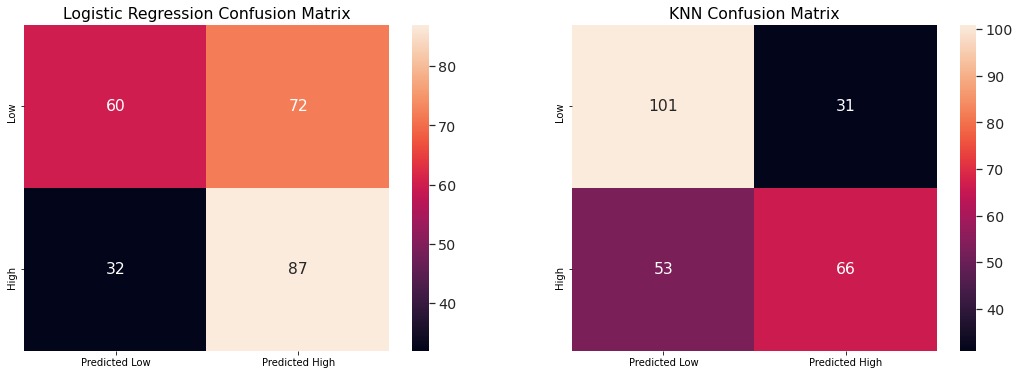

In [13]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(18,6)
dfk_cm = pd.DataFrame(cmk_test, index = ['Low','High'],columns = ['Predicted Low','Predicted High'])
df_cm = pd.DataFrame(cm_test, index = ['Low','High'],columns = ['Predicted Low','Predicted High'])
sns.set(font_scale=1.3)
sns.heatmap(df_cm.iloc[-1::-1,:], annot=True,fmt= 'g', ax = axes[0])
axes[0].set_ylim([0,2]);
axes[0].set_title('Logistic Regression Confusion Matrix')
# fig.savefig('Logistic_CM.png')
sns.heatmap(dfk_cm.iloc[-1::-1,:], annot=True,fmt= 'g', ax = axes[1])
axes[1].set_ylim([0,2]);
axes[1].set_title('KNN Confusion Matrix');

## **Sensitivity**

The **Sensitivity**, also known as **Recall** or **True Positive Rate(TPR)**


$$TPR = Recall = \frac{TP}{OP} = \frac{TP}{TP+FN},$$

also called the **Hit Rate**: the fraction of observed positives (1s) the classifier gets right, or how many true positives were recalled. Maximizing the recall towards 1 means keeping down the false negative rate

In [14]:
recall = (cm_test[1][1])/cm_test.sum(axis=1)[1]
knn_recall = (cmk_test[1][1])/cmk_test.sum(axis=1)[1]
print(f'True Positive Rate (Recall) for Logistic Regression = {100*round(recall,2)} %')
print(f'True Positive Rate (Recall) for KNN = {100*round(knn_recall,1)} %')

True Positive Rate (Recall) for Logistic Regression = 73.0 %
True Positive Rate (Recall) for KNN = 60.0 %


## **Specificity**
The **Specificity** or **True Negative Rate** is defined as

$$TNR = \frac{TN}{ON} = \frac{TN}{FP+TN}$$

also called the **False Alarm Rate**, the fraction of observed negatives (0s) the classifier gets wrong. In general, you want this number to be low. 

In [15]:
fpr = (cm_test[0][1])/cm_test.sum(axis=1)[0]
knn_fpr = (cmk_test[0][1])/cmk_test.sum(axis=1)[0]
print(f'False Positive Rate for Logistic Regression = {100*round(fpr,1)} %')
print(f'False Positive Rate for KNN = {100*round(knn_fpr,2)} %')

False Positive Rate for Logistic Regression = 50.0 %
False Positive Rate for KNN = 23.0 %


## **Precision**

**Precision**,tells you how many of the predicted positive(1) hits were truly positive

$$Precision = \frac{TP}{PP} = \frac{TP}{TP+FP}.$$

In [21]:
precision = (cm_test[1][1])/cm_test.sum(axis=0)[1]
knn_precision = (cmk_test[1][1])/cmk_test.sum(axis=0)[1]
print(f'Precision Rate for Logistic Regression = {100*round(precision,4)} %')
print(f'Precision Rate for KNN = {100*round(knn_precision,2)} %')

Precision Rate for Logistic Regression = 65.79 %
Precision Rate for KNN = 72.0 %


## **F1 score**
**F1** score gives us the Harmonic Mean of Precision and Recall.
It tries to minimize both **false positives** and **false negatives** simultaneously

$$F1 =  \frac{2*Recall*Precision}{Recall + Precision}$$

In [25]:
f1_score = (2*precision*recall)/(recall+precision)
knn_f1_score = (2*knn_precision*knn_recall)/(knn_recall+knn_precision)
print(f'F1 score for Logistic Regression = {100*round(f1_score,2)} %')
print(f'F1 score for KNN = {100*round(knn_f1_score,2)} %')

F1 score for Logistic Regression = 72.0 %
F1 score for KNN = 69.0 %


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y[~mask],logreg.predict(X[~mask])))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65       125
           1       0.66      0.79      0.72       126

    accuracy                           0.69       251
   macro avg       0.70      0.69      0.69       251
weighted avg       0.70      0.69      0.69       251



In [27]:
from sklearn.metrics import classification_report
print(classification_report(y[~mask],neigh.predict(X[~mask])))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71       125
           1       0.72      0.66      0.69       126

    accuracy                           0.70       251
   macro avg       0.70      0.70      0.70       251
weighted avg       0.70      0.70      0.70       251



## Note for Pavlos

1. Missing definition for **Prevalance**
2. Missing definition for **Poistive Predicted Value**
3. Missing definition for **Negative Predicted Value**


## Bayes Theorem & Diagnostic testing

Refer to Rahul's [Covid19 Serological testing blog](https://covid19.posts.ai/2020/04/04/bayes-rule-and-serological-testing.html) for an excellent introduction to the above concepts

## ROC Curve

To make a ROC curve you plot the True Positive Rate, against the False Positive Rate,

The curve is actually a 3 dimensional plot, which each point representing a different value of threshold.

![ROC](https://github.com/hargun3045/blog-dump/blob/master/pavloss6/roc-curve.png?raw=true)


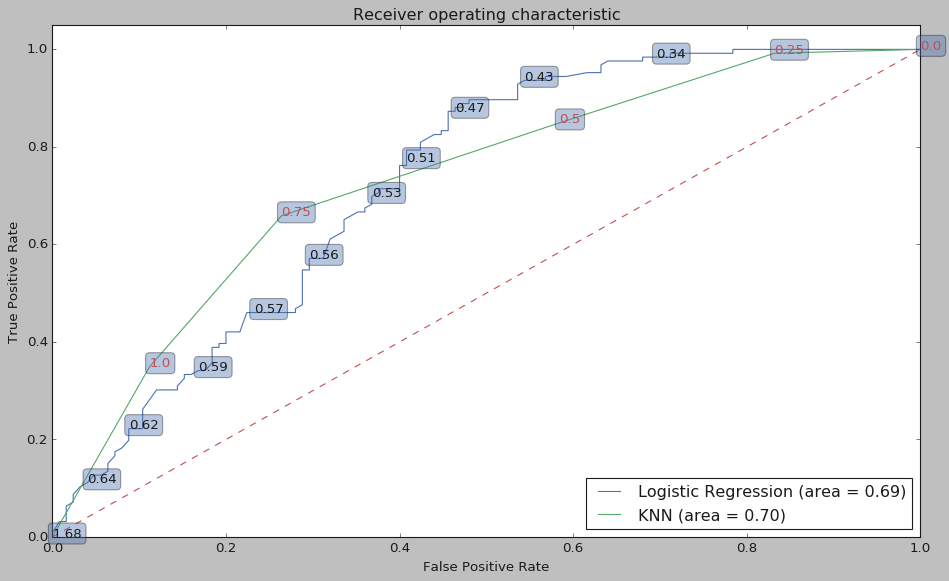

In [28]:
#Import stuff
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.style.use('classic')
# Area under curve - Logistic regression & KNN
yvals = 1*(y[~mask].values == 1)
ypredvals = 1*(logreg.predict(X[~mask])==1)
ykpredvals = 1*(neigh.predict(X[~mask])==1)
#logreg_roc_auc = roc_auc_score(y[~mask],logreg.predict(X[~mask]))
logreg_roc_auc = roc_auc_score(yvals,ypredvals)
#knn_roc_auc = roc_auc_score(y[~mask],neigh.predict(X[~mask]))
knn_roc_auc = roc_auc_score(yvals,ykpredvals)

#ROC Curve values
fpr, tpr, thresholds = roc_curve(yvals, logreg.predict_proba(X[~mask])[:,1])
kfpr, ktpr, kthresholds = roc_curve(yvals, neigh.predict_proba(X[~mask])[:,1])
fig, ax = plt.subplots(figsize = (14,8))

ax.plot(fpr, tpr, label=f'Logistic Regression (area = {logreg_roc_auc:.2f})', color = 'b')
ax.plot(kfpr, ktpr, label=f'KNN (area = {knn_roc_auc:.2f})', color = 'g')

label_kwargs = {}
label_kwargs['bbox'] = dict(
    boxstyle='round,pad=0.3', alpha=0.4,
)

#
for k in range(0, fpr.shape[0],10):
    #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
    threshold = str(np.round(thresholds[k], 2))
    ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
for k in range(1, kfpr.shape[0]):
    #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
    threshold = str(np.round(kthresholds[k], 2))
    ax.annotate(threshold, (kfpr[k], ktpr[k]),color='r', **label_kwargs)

ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right");

# Model In action

[![Covid-19 detector](https://github.com/hargun3045/blog-dump/blob/master/hargun-images/app.png?raw=true)](https://covid19-app-272409.appspot.com/)